https://www.kaggle.com/c/titanic/data

In [2]:
import pandas as pd
import random
from random import randint
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import catboost as cb
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#### Открываю в ноутбуке файл с данными ("train.csv") и вывожу первые и последние 5 строк датафрейма

In [4]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 1. Препроцессинг данных

## 1.1 Анализ данных

#### 1.1.1 Размер датафрейма

In [8]:
train.shape

(891, 12)

#### 1.1.2 Баланс классов

In [133]:
train['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

#### 1.1.3 Для каждого из признаков указываю его тип (вещественный, категориальный, порядковый, другое)

In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### 1.1.4 Выясняю какова доля выживших после крушения:
    - всех пассажиров
    - мужчин
    - женщин

In [12]:
# всех пасажиров
x = train['Survived'].value_counts()
print(f'{x[1]/(x[0]+x[1]):.2f}')

0.38


In [13]:
# мужчин
x = train[train['Sex']=='male']['Survived'].value_counts()
print(f'{x[1]/(x[0]+x[1]):.2f}')

0.19


In [14]:
# женщин
x = train[train['Sex']=='female']['Survived'].value_counts()
print(f'{x[1]/(x[0]+x[1]):.2f}')

0.74


#### 1.1.5 Сколько пассажиров ехало в каждом классе

In [16]:
train['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

#### 1.1.6 Сколько в среднем пассажиры заплатили за проезд

In [18]:
train['Fare'].mean().round(4)

32.2042

#### 1.1.7 Правда ли, что чаще выживали пассажиры с более дорогими билетами?

In [20]:
print(f"Средняя цена билета среди выживших {train[train['Survived']==1]['Fare'].mean():.2f}")
print(f"Средняя цена билета среди погибших {train[train['Survived']==0]['Fare'].mean()}")
print(f"Отношение разницы средней цены билета у выживших и погибших к разнице максимальной и минимальной цены билета {(train[train['Survived']==1]['Fare'].mean()-train[train['Survived']==0]['Fare'].mean())/(train['Fare'].max()-train['Fare'].min()):.2f}")
print(f"Медианная цена билета среди выживших {train[train['Survived']==1]['Fare'].median()}")
print(f"Медианная цена билета среди погибших {train[train['Survived']==0]['Fare'].median()}")
print(f"Отношение разницы медианной цены билета у выживших и погибших к разнице максимальной и минимальной цены билета {(train[train['Survived']==1]['Fare'].median()-train[train['Survived']==0]['Fare'].median())/(train['Fare'].max()-train['Fare'].min()):.2f}")


Средняя цена билета среди выживших 48.40
Средняя цена билета среди погибших 22.117886885245902
Отношение разницы средней цены билета у выживших и погибших к разнице максимальной и минимальной цены билета 0.05
Медианная цена билета среди выживших 26.0
Медианная цена билета среди погибших 10.5
Отношение разницы медианной цены билета у выживших и погибших к разнице максимальной и минимальной цены билета 0.03


In [21]:
train[['Survived','Fare']].corr()

,Survived,Fare
Survived,1.000000,0.257307
Fare,0.257307,1.000000


 Хоть корреляция не сильная, однако она есть.

#### 1.1.8 Какая фамилия была самой популярной на корабле?

In [24]:
Names = pd.read_csv('train.csv')['Name']
Names

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [25]:
def second_name(str):
    try:
        return re.match(r'[A-Z][a-z]*,', str).group()[:-1]
    except AttributeError:
        return ''

In [26]:
Names = Names.apply(second_name)
Names

0         Braund
1        Cumings
2      Heikkinen
3       Futrelle
4          Allen
         ...    
886     Montvila
887       Graham
888     Johnston
889         Behr
890       Dooley
Name: Name, Length: 891, dtype: object

In [27]:
Names.value_counts()

Name
             58
Andersson     9
Sage          7
Carter        6
Panula        6
             ..
Saalfeld      1
Hanna         1
Lewy          1
Mineff        1
Dooley        1
Name: count, Length: 621, dtype: int64

##### Ответ - Andersson

## 1.2 Удаление неифнормативных признаков

**На мой взгляд от признаков name и ticket можно избавиться.** 
- Name сложнее остальных превратить в численные признаки, при этом полезная информация в виде социального статуса есть в других столбцах, а здравый смысл подсказывает, что именно от букв имени выживание не должно зависеть. Можно было бы ввести отдельный признак, который бы отвечал за Mr или Ms
- ticket так же сложно интерпретировать, при этом информация о стоимости и местоположении в момент аварии содержиться в других столбцах.
- PassengerId структуру данных dataframe уже имеет встроенный индекс

In [31]:
train = train.drop(columns=['Name','Ticket', 'PassengerId'])
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C148,C


## 1.3 Обработка пропущенных значений

#### 1.3.1 Есть ли в данных пропуски? В каких столбцах: сколько пропусков в каждом из них?

In [34]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

#### 1.3.2 Избавляюсь от пропусков

In [36]:
print(f"Пропущенные значения в Cabin составляют {train['Cabin'].isna().sum()/len(train)*100:.2f}%")
print(f"Пропущенные значения в Age составляют {train['Age'].isna().sum()/len(train)*100:.2f}%")
print(f"Пропущенные значения в Embarked составляют {train['Embarked'].isna().sum()/len(train)*100:.2f}%")

Пропущенные значения в Cabin составляют 77.10%
Пропущенные значения в Age составляют 19.87%
Пропущенные значения в Embarked составляют 0.22%


##### Реализация удаления столбцов по трешхолду в 30%

In [38]:
for col in train.columns:
    print(f"Пропущенные значения в {col} составляют {train[col].isna().sum()/len(train)*100:.2f}%")
    if train[col].isna().sum()/len(train) > 0.3:
        train = train.drop(columns=[col])
        print(f"Атрибут {col} убран")
train

Пропущенные значения в Survived составляют 0.00%
Пропущенные значения в Pclass составляют 0.00%
Пропущенные значения в Sex составляют 0.00%
Пропущенные значения в Age составляют 19.87%
Пропущенные значения в SibSp составляют 0.00%
Пропущенные значения в Parch составляют 0.00%
Пропущенные значения в Fare составляют 0.00%
Пропущенные значения в Cabin составляют 77.10%
Атрибут Cabin убран
Пропущенные значения в Embarked составляют 0.22%


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


Заполнения поля age

In [40]:
train['Age'].mean().round(2)

29.7

1.69911764705882


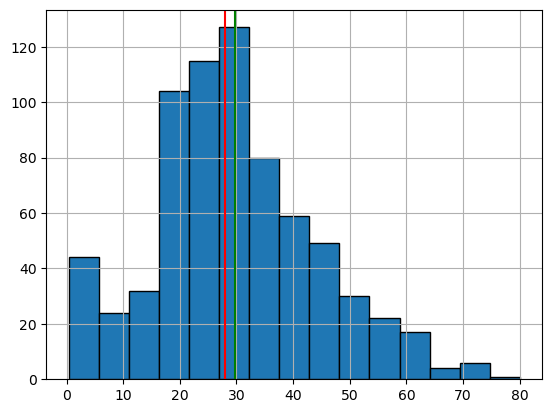

In [41]:
import matplotlib.pyplot as plt
ax = train['Age'].hist(bins=15, edgecolor='black')
median = train['Age'].median()
mean = train['Age'].mean()
ax.axvline(median, color='red')
ax.axvline(mean, color='green')
print(mean-median)
plt.show()


##### Заполняем пропущенные значение Age средним

In [43]:
train['Age']=train['Age'].fillna(train['Age'].mean())
print(train['Age'].mean().round(2))
train.isna().sum()

29.7


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

##### Реализовал заполнение данных случайным образом соответствуя распределению признаков в датасете

In [45]:
nan_index = train[train.isna().any(axis=1)].index
nan_index
train.iloc[nan_index]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [46]:
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [47]:
def raspr(x):
    if x<645:
        return 'S'
    elif x<645+168:
        return 'C'
    else:
        return 'Q'

In [48]:
raspr(randint(1,len(train)))

'S'

In [49]:
for i in nan_index:
    train.loc[i, 'Embarked']=raspr(randint(1,len(train)))
train.iloc[nan_index]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,S
829,1,1,female,62.0,0,0,80.0,C


In [50]:
train.isna().any().any()

False

## 1.4 Создание новых признаков (feature engineering)

#### 1.4.1 Добавляю признак: Relation - сколько родных плыло вместе с пассажиром на корабле, включая его самого

In [53]:
train['Relation']=train['SibSp']+train['Parch']+1
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Relation
0,0,3,male,22.000000,1,0,7.2500,S,2
1,1,1,female,38.000000,1,0,71.2833,C,2
2,1,3,female,26.000000,0,0,7.9250,S,1
3,1,1,female,35.000000,1,0,53.1000,S,2
4,0,3,male,35.000000,0,0,8.0500,S,1
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S,1
887,1,1,female,19.000000,0,0,30.0000,S,1
888,0,3,female,29.699118,1,2,23.4500,S,4
889,1,1,male,26.000000,0,0,30.0000,C,1


#### 1.4.2 Реализую вышеупомянутую идею. Приставки mr, ms, miss, mrs несут в себе информацию о социальном статусе:
- Mr - мужчина, чьего социального статуса мы не знаем
- Ms - женщина, чьего социального статуса мы не знаем
- Miss - незамужняя женщина
- Mrs - замужняя женщина

Введу категориальный признак - Married, 

In [55]:
Names = pd.read_csv('train.csv')['Name']
Names

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [56]:
def marrie_status(str):
    if re.search(r'Miss\.', str):
        return 'Unmarried'
    elif re.search(r'Mrs\.', str):
        return 'Married'
    else:
        return 'Unknown'

In [57]:
Names = Names.apply(marrie_status)
Names.name = 'marrie_status'
Names

0        Unknown
1        Married
2      Unmarried
3        Married
4        Unknown
         ...    
886      Unknown
887    Unmarried
888    Unmarried
889      Unknown
890      Unknown
Name: marrie_status, Length: 891, dtype: object

In [58]:
train = pd.concat([train, Names], axis=1)
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Relation,marrie_status
0,0,3,male,22.000000,1,0,7.2500,S,2,Unknown
1,1,1,female,38.000000,1,0,71.2833,C,2,Married
2,1,3,female,26.000000,0,0,7.9250,S,1,Unmarried
3,1,1,female,35.000000,1,0,53.1000,S,2,Married
4,0,3,male,35.000000,0,0,8.0500,S,1,Unknown
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S,1,Unknown
887,1,1,female,19.000000,0,0,30.0000,S,1,Unmarried
888,0,3,female,29.699118,1,2,23.4500,S,4,Unmarried
889,1,1,male,26.000000,0,0,30.0000,C,1,Unknown


## 1.5 Превращение категориальных признаков в численные

(Далее будт решено использовать catboost, который умеет самостятельно хорошо обрабатывать категориальные признаки, поэтому создам на этом 
этапе копию с оставленными категориальными признаками)

In [60]:
cols_obj = train.columns[train.dtypes == 'object']
for col in cols_obj:
    print(col, ': ', pd.unique(train[col]))

Sex :  ['male' 'female']
Embarked :  ['S' 'C' 'Q']
marrie_status :  ['Unknown' 'Married' 'Unmarried']


In [61]:
train_no_cat = train.copy(deep=True)

#### 1.5.1 Признак Sex является бинарным, поэтому его можно сразу заменить вручную

In [63]:
train_no_cat['Sex_bin'] = train_no_cat['Sex'].apply(lambda x: 1.0 if x=='male' else 0.0)
train_no_cat[['Sex', 'Sex_bin']]

,Sex,Sex_bin
0,male,1.0
1,female,0.0
2,female,0.0
3,female,0.0
4,male,1.0
...,...,...
886,male,1.0
887,female,0.0
888,female,0.0
889,male,1.0


In [64]:
train_no_cat.drop(columns=['Sex'], inplace=True)

In [65]:
cols_obj = list(cols_obj)
cols_obj.remove('Sex')
cols_obj

['Embarked', 'marrie_status']

#### 1.5.2 Остальные признаки не имеют логической последовательности, а значит к ним нельзя применить label encoding, а можно OHE

In [67]:
dummies = pd.get_dummies(train_no_cat[cols_obj], drop_first=True) # Используем drop first, чтобы избежать мульиколлениарности
dummies

,Embarked_Q,Embarked_S,marrie_status_Unknown,marrie_status_Unmarried
0,False,True,True,False
1,False,False,False,False
2,False,True,False,True
3,False,True,False,False
4,False,True,True,False
...,...,...,...,...
886,False,True,True,False
887,False,True,False,True
888,False,True,False,True
889,False,False,True,False


In [68]:
for col in dummies.columns:
    dummies[col]=dummies[col].apply(lambda x: 1 if x else 0)
dummies

,Embarked_Q,Embarked_S,marrie_status_Unknown,marrie_status_Unmarried
0,0,1,1,0
1,0,0,0,0
2,0,1,0,1
3,0,1,0,0
4,0,1,1,0
...,...,...,...,...
886,0,1,1,0
887,0,1,0,1
888,0,1,0,1
889,0,0,1,0


In [69]:
train_no_cat = pd.concat([train_no_cat.drop(columns=cols_obj), dummies], axis=1)
train_no_cat

,Survived,Pclass,Age,SibSp,Parch,Fare,Relation,Sex_bin,Embarked_Q,Embarked_S,marrie_status_Unknown,marrie_status_Unmarried
0,0,3,22.000000,1,0,7.2500,2,1.0,0,1,1,0
1,1,1,38.000000,1,0,71.2833,2,0.0,0,0,0,0
2,1,3,26.000000,0,0,7.9250,1,0.0,0,1,0,1
3,1,1,35.000000,1,0,53.1000,2,0.0,0,1,0,0
4,0,3,35.000000,0,0,8.0500,1,1.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,1,1.0,0,1,1,0
887,1,1,19.000000,0,0,30.0000,1,0.0,0,1,0,1
888,0,3,29.699118,1,2,23.4500,4,0.0,0,1,0,1
889,1,1,26.000000,0,0,30.0000,1,1.0,0,0,1,0


In [70]:
cols_obj = train.columns[train.dtypes == 'object']
cols_obj

Index(['Sex', 'Embarked', 'marrie_status'], dtype='object')

## 1.6 Разбиение на train и valid

#### 1.6.1 Разбиение датасета с категориальными признаками

In [73]:
x_train, x_valid, y_train, y_valid = train_test_split(train.drop(columns=['Survived']), train['Survived'], shuffle=True, random_state=42, test_size=0.25)
x_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Relation,marrie_status
298,1,male,29.699118,0,0,30.5000,S,1,Unknown
884,3,male,25.000000,0,0,7.0500,S,1,Unknown
247,2,female,24.000000,0,2,14.5000,S,3,Married
478,3,male,22.000000,0,0,7.5208,S,1,Unknown
305,1,male,0.920000,1,2,151.5500,S,4,Unknown
...,...,...,...,...,...,...,...,...,...
106,3,female,21.000000,0,0,7.6500,S,1,Unmarried
270,1,male,29.699118,0,0,31.0000,S,1,Unknown
860,3,male,41.000000,2,0,14.1083,S,3,Unknown
435,1,female,14.000000,1,2,120.0000,S,4,Unmarried


#### 1.6.2 Разбиение датасета без категориальных признаков

In [75]:
x_train_no_cat, x_valid_no_cat, y_train_no_cat, y_valid_no_cat = train_test_split(train_no_cat.drop(columns=['Survived']), train_no_cat['Survived'], shuffle=True, random_state=42, test_size=0.25)
x_train_no_cat

,Pclass,Age,SibSp,Parch,Fare,Relation,Sex_bin,Embarked_Q,Embarked_S,marrie_status_Unknown,marrie_status_Unmarried
298,1,29.699118,0,0,30.5000,1,1.0,0,1,1,0
884,3,25.000000,0,0,7.0500,1,1.0,0,1,1,0
247,2,24.000000,0,2,14.5000,3,0.0,0,1,0,0
478,3,22.000000,0,0,7.5208,1,1.0,0,1,1,0
305,1,0.920000,1,2,151.5500,4,1.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
106,3,21.000000,0,0,7.6500,1,0.0,0,1,0,1
270,1,29.699118,0,0,31.0000,1,1.0,0,1,1,0
860,3,41.000000,2,0,14.1083,3,1.0,0,1,1,0
435,1,14.000000,1,2,120.0000,4,0.0,0,1,0,1


## 1.7 Скалирование признаков
В данной работе я так же решил оставить неотсклаированные данные и посмотреть повлияет ли этот пункт положительным образом на результат.
Поскольку в работе используется catboost в качестве модели, который является градиентным бустингом решающих деревьев, то гипотеза заключается в том, что скалирование данных не должно повлиять положительно на результат, так как последнее является нелинейной моделью.

#### 1.7.1 Скалирование датасета без категориальных признаков

In [78]:
scaler = MinMaxScaler()

x_train_cat_cat = x_train[cols_obj]
x_train_cat_no_cat = x_train[list(set(x_train.columns) - set(cols_obj))]
x_valid_cat_cat = x_valid[cols_obj]
x_valid_cat_no_cat = x_valid[list(set(x_train.columns) - set(cols_obj))]


# Подгоняем scaler на обучающем датасете
scaler.fit(x_train_cat_no_cat)

# Применяем преобразование к обучающему датасету
x_train_scaled = scaler.transform(x_train_cat_no_cat)

# Применяем преобразование к валидационному датасету
x_valid_scaled = scaler.transform(x_valid_cat_no_cat)

# Применяем преобразование к тестовому датасету
#test_scaled = scaler.transform(test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train_cat_no_cat.columns, index=y_train.index)

x_valid_scaled = pd.DataFrame(x_valid_scaled, columns=x_valid_cat_no_cat.columns, index=y_valid.index)




#test_scaled = pd.DataFrame(test_scaled, columns=test.columns)


x_train_scaled = pd.concat([x_train_scaled, x_train_cat_cat], axis=1)
x_valid_scaled = pd.concat([x_valid_scaled, x_valid_cat_cat], axis=1)

In [79]:
x_train_scaled

,Pclass,Age,Relation,SibSp,Parch,Fare,Sex,Embarked,marrie_status
298,0.0,0.367921,0.0,0.000,0.000000,0.059532,male,S,Unknown
884,1.0,0.308872,0.0,0.000,0.000000,0.013761,male,S,Unknown
247,0.5,0.296306,0.2,0.000,0.333333,0.028302,female,S,Married
478,1.0,0.271174,0.0,0.000,0.000000,0.014680,male,S,Unknown
305,0.0,0.006283,0.3,0.125,0.333333,0.295806,male,S,Unknown
...,...,...,...,...,...,...,...,...,...
106,1.0,0.258608,0.0,0.000,0.000000,0.014932,female,S,Unmarried
270,0.0,0.367921,0.0,0.000,0.000000,0.060508,male,S,Unknown
860,1.0,0.509927,0.2,0.250,0.000000,0.027538,male,S,Unknown
435,0.0,0.170646,0.3,0.125,0.333333,0.234224,female,S,Unmarried


#### 1.7.2 Скалирование датасета c категориальными признаками

In [81]:
scaler = MinMaxScaler()



# Подгоняем scaler на обучающем датасете
scaler.fit(x_train_no_cat)

# Применяем преобразование к обучающему датасету
x_train_scaled_no_cat = scaler.transform(x_train_no_cat)

# Применяем преобразование к валидационному датасету
x_valid_scaled_no_cat = scaler.transform(x_valid_no_cat)

# Применяем преобразование к тестовому датасету
#test_scaled = scaler.transform(test)

x_train_scaled_no_cat = pd.DataFrame(x_train_scaled_no_cat, columns=x_train_no_cat.columns, index=y_train.index)

x_valid_scaled_no_cat = pd.DataFrame(x_valid_scaled_no_cat, columns=x_valid_no_cat.columns, index=y_valid.index)




#test_scaled = pd.DataFrame(test_scaled, columns=test.columns)



In [82]:
x_train_scaled_no_cat

,Pclass,Age,SibSp,Parch,Fare,Relation,Sex_bin,Embarked_Q,Embarked_S,marrie_status_Unknown,marrie_status_Unmarried
298,0.0,0.367921,0.000,0.000000,0.059532,0.0,1.0,0.0,1.0,1.0,0.0
884,1.0,0.308872,0.000,0.000000,0.013761,0.0,1.0,0.0,1.0,1.0,0.0
247,0.5,0.296306,0.000,0.333333,0.028302,0.2,0.0,0.0,1.0,0.0,0.0
478,1.0,0.271174,0.000,0.000000,0.014680,0.0,1.0,0.0,1.0,1.0,0.0
305,0.0,0.006283,0.125,0.333333,0.295806,0.3,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
106,1.0,0.258608,0.000,0.000000,0.014932,0.0,0.0,0.0,1.0,0.0,1.0
270,0.0,0.367921,0.000,0.000000,0.060508,0.0,1.0,0.0,1.0,1.0,0.0
860,1.0,0.509927,0.250,0.000000,0.027538,0.2,1.0,0.0,1.0,1.0,0.0
435,0.0,0.170646,0.125,0.333333,0.234224,0.3,0.0,0.0,1.0,0.0,1.0


**В данном разделе был применен метод из статьи https://medium.com/towards-data-science/data-leakage-in-preprocessing-explained-a-visual-guide-with-code-examples-33cbf07507b7, который заключается в том, что во избежание утечки данных из обучающей выборки в тестовую (что может испортить оценку нашей модели) мы скалируем данные всех выборок по параметрам полученным только из обучающей.**

# 2. Обучение модели

## 2.1 Используем встроенную в catboost обработку категориальных признаков и неотскалированные данные

In [87]:
train_dataset = cb.Pool(x_train,y_train,
                        cat_features=list(cols_obj))                                                     
valid_dataset = cb.Pool(x_valid,y_valid,          
                       cat_features=list(cols_obj))


In [88]:
model1 = cb.CatBoostClassifier(loss_function='Logloss', 
                              eval_metric='Accuracy')
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100, 150]}

In [89]:
model1.grid_search(grid,train_dataset, verbose=False)

0:	learn: 0.8314607	test: 0.8208955	best: 0.8208955 (0)	total: 163ms	remaining: 7.98s
1:	learn: 0.8333333	test: 0.8208955	best: 0.8208955 (0)	total: 176ms	remaining: 4.23s
2:	learn: 0.8258427	test: 0.8059701	best: 0.8208955 (0)	total: 189ms	remaining: 2.96s
3:	learn: 0.8220974	test: 0.7835821	best: 0.8208955 (0)	total: 206ms	remaining: 2.37s
4:	learn: 0.8258427	test: 0.8059701	best: 0.8208955 (0)	total: 222ms	remaining: 2s
5:	learn: 0.8370787	test: 0.8134328	best: 0.8208955 (0)	total: 241ms	remaining: 1.77s
6:	learn: 0.8295880	test: 0.8134328	best: 0.8208955 (0)	total: 259ms	remaining: 1.59s
7:	learn: 0.8295880	test: 0.8134328	best: 0.8208955 (0)	total: 275ms	remaining: 1.44s
8:	learn: 0.8295880	test: 0.8059701	best: 0.8208955 (0)	total: 296ms	remaining: 1.35s
9:	learn: 0.8277154	test: 0.8059701	best: 0.8208955 (0)	total: 305ms	remaining: 1.22s
10:	learn: 0.8258427	test: 0.8059701	best: 0.8208955 (0)	total: 323ms	remaining: 1.15s
11:	learn: 0.8333333	test: 0.8134328	best: 0.8208955 (0)

{'params': {'depth': 6,
  'learning_rate': 0.1,
  'l2_leaf_reg': 1,
  'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [90]:
pred = model1.predict(x_valid)
print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       134
           1       0.83      0.70      0.76        89

    accuracy                           0.82       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



## 2.2 Используем встроенную в catboost обработку категориальных признаков и отскалированные данные

In [92]:
train_dataset = cb.Pool(x_train_scaled,y_train,
                        cat_features=list(cols_obj))                                                     
valid_dataset = cb.Pool(x_valid_scaled,y_valid,          
                       cat_features=list(cols_obj))

In [93]:
model2 = cb.CatBoostClassifier(loss_function='Logloss', 
                              eval_metric='Accuracy')
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100, 150]}

In [94]:
model2.grid_search(grid,train_dataset)

0:	learn: 0.8089888	test: 0.7835821	best: 0.7835821 (0)	total: 15ms	remaining: 735ms
1:	learn: 0.8089888	test: 0.7835821	best: 0.7835821 (0)	total: 24.8ms	remaining: 595ms
2:	learn: 0.8089888	test: 0.7835821	best: 0.7835821 (0)	total: 35.3ms	remaining: 553ms
3:	learn: 0.8071161	test: 0.7835821	best: 0.7835821 (0)	total: 48.4ms	remaining: 556ms
4:	learn: 0.8164794	test: 0.7985075	best: 0.7985075 (4)	total: 66.3ms	remaining: 596ms
5:	learn: 0.8220974	test: 0.7985075	best: 0.7985075 (4)	total: 83.1ms	remaining: 610ms
6:	learn: 0.8202247	test: 0.7985075	best: 0.7985075 (4)	total: 95.5ms	remaining: 587ms
7:	learn: 0.8202247	test: 0.7910448	best: 0.7985075 (4)	total: 111ms	remaining: 585ms
8:	learn: 0.8202247	test: 0.7761194	best: 0.7985075 (4)	total: 128ms	remaining: 582ms
9:	learn: 0.8164794	test: 0.7686567	best: 0.7985075 (4)	total: 141ms	remaining: 564ms
10:	learn: 0.8239700	test: 0.7985075	best: 0.7985075 (4)	total: 154ms	remaining: 547ms
11:	learn: 0.8239700	test: 0.7835821	best: 0.798

{'params': {'depth': 10,
  'learning_rate': 0.1,
  'l2_leaf_reg': 1,
  'iterations': 50},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [95]:
pred = model2.predict(x_valid)
print(classification_report(y_valid, pred))

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="male": Cannot convert 'male' to float